In [3]:
import tejapi as tej
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

tej.ApiConfig.api_key = 'Your Key '

plt.rcParams['font.family'] = 'Noto Sans TC'

%matplotlib inline

In [4]:
#上市櫃公司代號

price = tej.get('TWN/APRCD', 
                coid='2330',
                mdate={'gt': '2015-01-01', 'lt':'2022-11-28'}, 
                opts={'columns': ['coid', 'mdate', 'close_d', 'high_d', 'low_d', 'open_d']},
                chinese_column_name=True, 
                paginate=True)


price['年月日'] = price['年月日'].dt.date
price = price.reset_index(drop=True)

In [5]:
price

,證券代碼,年月日,收盤價(元),最高價(元),最低價(元),開盤價(元)
0,2330,2015-01-05,139.5,140.5,137.5,140.5
1,2330,2015-01-06,133.5,137.5,133.0,137.5
2,2330,2015-01-07,134.0,135.0,133.5,133.5
3,2330,2015-01-08,138.0,138.0,136.0,136.5
4,2330,2015-01-09,134.0,135.5,133.0,135.0
...,...,...,...,...,...,...
1928,2330,2022-11-21,482.0,489.5,480.5,487.5
1929,2330,2022-11-22,491.0,491.0,476.0,476.0
1930,2330,2022-11-23,492.0,496.0,488.5,494.5
1931,2330,2022-11-24,496.0,496.0,492.0,494.0


### 乖離率計算

In [6]:
def bias_cal(tmp ,n):
    
    df = tmp.copy()

    df['BIAS'] = ((df['收盤價(元)'] - df['收盤價(元)'].rolling(n).mean()) / df['收盤價(元)'].rolling(n).mean()).round(4)

    return df

In [7]:
bias_cal(price, 20).tail(10)

,證券代碼,年月日,收盤價(元),最高價(元),最低價(元),開盤價(元),BIAS
1923,2330,2022-11-14,445.0,450.0,441.5,450.0,0.1222
1924,2330,2022-11-15,480.0,487.0,462.0,465.0,0.1994
1925,2330,2022-11-16,487.0,494.0,481.5,491.5,0.2031
1926,2330,2022-11-17,485.0,485.0,475.0,482.5,0.1854
1927,2330,2022-11-18,487.0,494.0,486.0,491.5,0.1763
1928,2330,2022-11-21,482.0,489.5,480.5,487.5,0.1510
1929,2330,2022-11-22,491.0,491.0,476.0,476.0,0.1559
1930,2330,2022-11-23,492.0,496.0,488.5,494.5,0.1427
1931,2330,2022-11-24,496.0,496.0,492.0,494.0,0.1374
1932,2330,2022-11-25,498.0,498.0,494.0,494.0,0.1266


### 回測計算

In [23]:
def performance(tmp, n, init=1000000):
    df = tmp.copy()

    signal = 0

    df['his_low'] = df['最低價(元)'].shift(n)
    df['his_high'] = df['最高價(元)'].shift(n)

    df.loc[0, '現金'] = init
    df['進出場'] = 0

    for i in range(1, len(df)):

        if (df.loc[i-1, '收盤價(元)'] > df.loc[i-1, 'his_high']) & (df.loc[i-1, 'BIAS'] < 0) & (signal == 0):   #前一天收盤價小於n天前最低價，且收盤乖離率<=0，則當天開盤價進場

            df.loc[i, '股票'] =  df.loc[i, '開盤價(元)'] * 1000
            df.loc[i, '交易成本'] = round(-df.loc[i, '開盤價(元)']*1000*0.001425)
            df.loc[i, '現金'] = df.loc[i-1, '現金'] - df.loc[i, '股票'] + df.loc[i, '交易成本']
            df.loc[i, '進出場'] = '進場建倉'
            
            signal = 1

        elif (df.loc[i-1, '收盤價(元)'] < df.loc[i-1, 'his_low']) & (df.loc[i-1, 'BIAS'] > 0) & (signal == 1):   #前一天收盤價大於n天前最高價，且收盤乖離率>=0，則當天開盤價出場

            df.loc[i, '股票'] =  0
            df.loc[i, '交易成本'] = round(-df.loc[i, '開盤價(元)']*1000*0.004425)
            df.loc[i, '現金'] = df.loc[i-1, '現金'] + df.loc[i, '開盤價(元)']*1000 + df.loc[i, '交易成本']
            df.loc[i, '進出場'] = '出場平倉'
            
            signal = 0

        elif signal == 1:

            df.loc[i, '股票'] = df.loc[i, '收盤價(元)'] * 1000

            df.loc[i, '現金'] = df.loc[i-1, '現金']

        else:

            df.loc[i, '現金'] = df.loc[i-1, '現金']
          

    df['股票'] = df['股票'].fillna(0)
    df['交易成本'] = df['交易成本'].fillna(0)
    df['總權益'] = df['現金'] + df['股票']

    print('總權益：', df['總權益'].iloc[-1])
    print('交易成本：', df['交易成本'].sum())
    print('報酬率：', '%.2f'%((df['總權益'].iloc[-1] - init)/init*100), '%')

    print('年均報酬率：', '%.3f'%(df['總權益'].pct_change().mean()*252*100), '%')
    print('年化標準差：', '%.3f'%(df['總權益'].pct_change().std()*np.sqrt(252)*100), '%')
    print('夏普值：', '%.3f'%((df['總權益'].pct_change().mean()*252*100) / (df['總權益'].pct_change().std()*np.sqrt(252)*100)))

    print('最大回撤：', '%.2f'%(((df['總權益'] / df['總權益'].cummax() - 1).cummin().iloc[-1])*100), '%')

    return df



In [25]:
result = performance(bias_cal(price, 20), 20)   

總權益： 1011657.0
交易成本： -51843.0
報酬率： 1.17 %
年均報酬率： 0.342 %
年化標準差： 6.177 %
夏普值： 0.055
最大回撤： -24.27 %


總權益： 1011657.0
交易成本： -51843.0
報酬率： 1.17 %
年均報酬率： 0.342 %
年化標準差： 6.177 %
夏普值： 0.055
最大回撤： -24.27 %


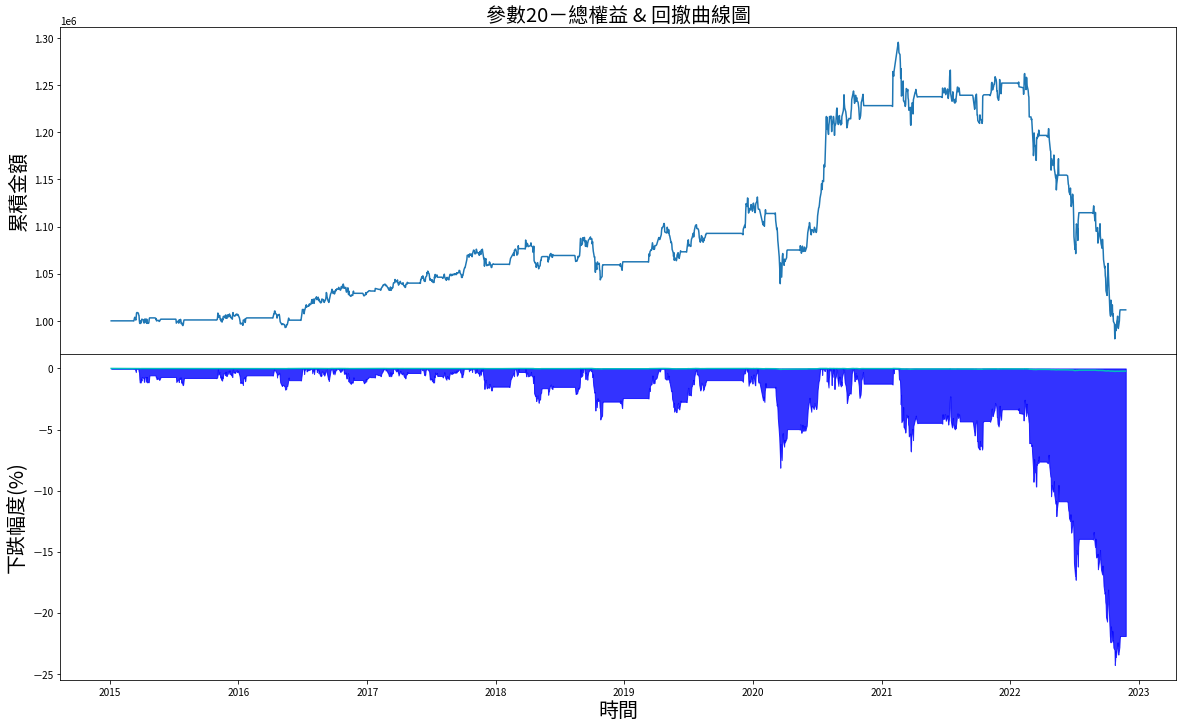

In [14]:
n = 20
result = performance(bias_cal(price, n), n)
fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)

ax[0].plot(result['年月日'], result['總權益'])

ax[1].plot(result['年月日'], result['總權益'].to_drawdown_series().to_list(), color='c')

dd = (result['總權益'].to_drawdown_series()*100).to_list()

ax[1].fill_between(result['年月日'], np.zeros(len(result['總權益'])), dd, label='大盤 DD', color='blue', linewidth=1, alpha=0.8)

ax[0].set_title(f'參數{n}－總權益 & 回撤曲線圖', fontsize=20)
ax[1].set_xlabel('時間', fontsize=20)

ax[0].set_ylabel('累積金額', fontsize=20)
ax[1].set_ylabel('下跌幅度(%)', fontsize=20)


plt.subplots_adjust(hspace=.0)


### 參數優化

In [29]:
optim = []
for i in range(2, 51):
    df = performance(bias_cal(price, i), i)

    sharp = ((df['總權益'].pct_change().mean()*252) / (df['總權益'].pct_change().std()*np.sqrt(252)))

    ret = round(((df['總權益'].iloc[-1] / df['總權益'].iloc[0]) - 1), 4)*100

    optim.append((i, sharp, ret))

    result1 = pd.DataFrame(optim, columns=['天數', '夏普值', '報酬率'])

result1.sort_values('夏普值', ascending=False).head(5)

總權益： 1139130.0
交易成本： -96870.0
報酬率： 13.91 %
年均報酬率： 1.896 %
年化標準差： 6.279 %
夏普值： 0.302
最大回撤： -18.23 %
總權益： 1101627.0
交易成本： -96373.0
報酬率： 10.16 %
年均報酬率： 1.426 %
年化標準差： 5.730 %
夏普值： 0.249
最大回撤： -13.58 %
總權益： 1361707.0
交易成本： -99793.0
報酬率： 36.17 %
年均報酬率： 4.209 %
年化標準差： 6.041 %
夏普值： 0.697
最大回撤： -9.51 %
總權益： 1010967.0
交易成本： -126033.0
報酬率： 1.10 %
年均報酬率： 0.291 %
年化標準差： 5.449 %
夏普值： 0.053
最大回撤： -12.15 %
總權益： 1113448.0
交易成本： -89052.0
報酬率： 11.34 %
年均報酬率： 1.602 %
年化標準差： 6.338 %
夏普值： 0.253
最大回撤： -17.11 %
總權益： 1392725.0
交易成本： -78275.0
報酬率： 39.27 %
年均報酬率： 4.467 %
年化標準差： 5.406 %
夏普值： 0.826
最大回撤： -17.13 %
總權益： 1123603.0
交易成本： -80897.0
報酬率： 12.36 %
年均報酬率： 1.649 %
年化標準差： 5.073 %
夏普值： 0.325
最大回撤： -12.58 %
總權益： 1140098.0
交易成本： -75402.0
報酬率： 14.01 %
年均報酬率： 1.840 %
年化標準差： 5.091 %
夏普值： 0.361
最大回撤： -13.65 %
總權益： 1161768.0
交易成本： -69732.0
報酬率： 16.18 %
年均報酬率： 2.105 %
年化標準差： 5.470 %
夏普值： 0.385
最大回撤： -10.83 %
總權益： 1148376.0
交易成本： -77624.0
報酬率： 14.84 %
年均報酬率： 1.968 %
年化標準差： 5.729 %
夏普值： 0.344
最大回撤： -12.75 %
總權益： 108821

,天數,夏普值,報酬率
5,7,0.826240,39.27
2,4,0.696710,36.17
39,41,0.659512,33.83
35,37,0.645226,31.18
37,39,0.613918,31.52


In [30]:
result = performance(bias_cal(price, 7), 7)   

總權益： 1392725.0
交易成本： -78275.0
報酬率： 39.27 %
年均報酬率： 4.467 %
年化標準差： 5.406 %
夏普值： 0.826
最大回撤： -17.13 %


總權益： 1392725.0
交易成本： -78275.0
報酬率： 39.27 %
年均報酬率： 4.467 %
年化標準差： 5.406 %
夏普值： 0.826
最大回撤： -17.13 %


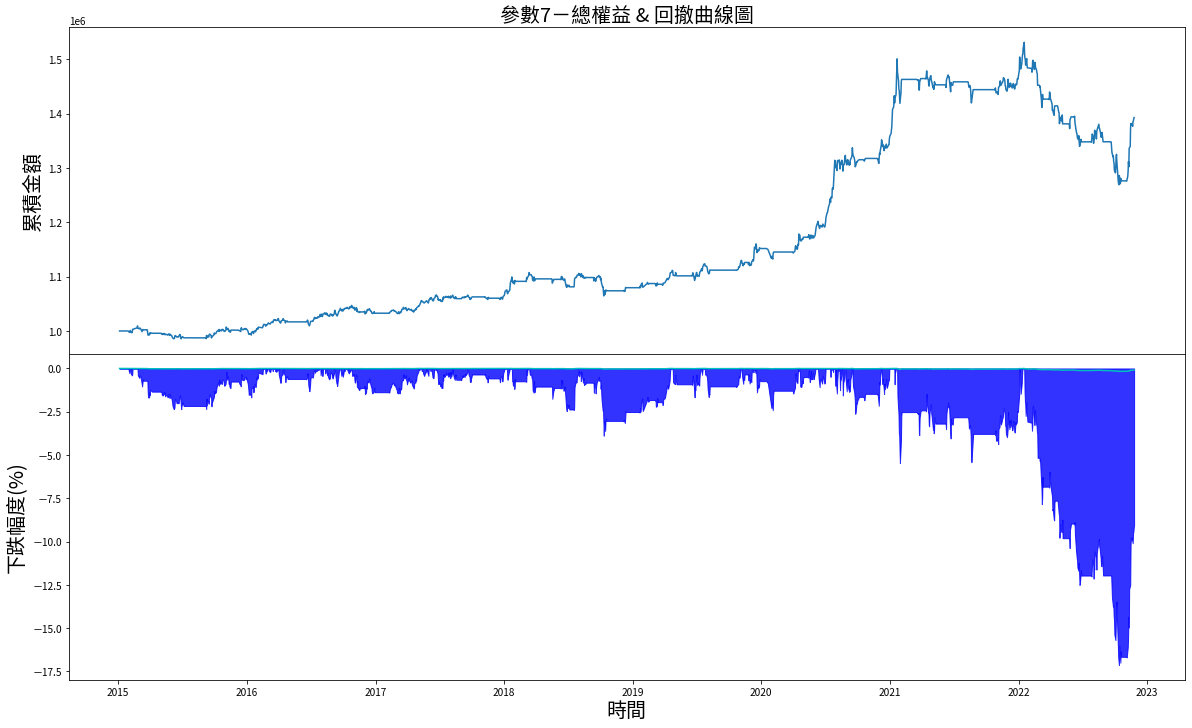

In [28]:
n = 7
result = performance(bias_cal(price, n), n)
fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)

ax[0].plot(result['年月日'], result['總權益'])

ax[1].plot(result['年月日'], result['總權益'].to_drawdown_series().to_list(), color='c')

dd = (result['總權益'].to_drawdown_series()*100).to_list()

ax[1].fill_between(result['年月日'], np.zeros(len(result['總權益'])), dd, label='大盤 DD', color='blue', linewidth=1, alpha=0.8)

ax[0].set_title(f'參數{n}－總權益 & 回撤曲線圖', fontsize=20)
ax[1].set_xlabel('時間', fontsize=20)

ax[0].set_ylabel('累積金額', fontsize=20)
ax[1].set_ylabel('下跌幅度(%)', fontsize=20)


plt.subplots_adjust(hspace=.0)
